# Network Data Analysis Report

## 1. Requests Per Device Per Second
In this section, we analyzed the request frequency for each device over time. We aggregated the number of requests made by each device per second to understand traffic patterns and detect potential anomalies. This metric helps identify devices generating excessive requests, which could indicate malicious activity, misconfigurations, or network congestion.

## 2. Device Contribution Ratio
Here, we computed the contribution ratio of each device to the overall network traffic. By calculating the proportion of requests each device contributes relative to the total, we can detect dominant devices and assess their impact on network load. A high contribution ratio from a single device may suggest unusual behavior, such as a DDoS attack or a misbehaving IoT device.

## 3. Burstiness Analysis
Burstiness measures fluctuations in network traffic over time, helping to detect irregular or suspicious request patterns. We analyzed time series data to identify periods of unusually high request rates. High burstiness levels can indicate cyber threats such as botnet activities, automated scanning, or other network anomalies requiring further investigation.

---

This analysis provides key insights into device behavior, network health, and potential security threats. Further refinement, such as anomaly detection techniques and machine learning-based pattern recognition, could enhance the accuracy of identifying suspicious activities.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


In [2]:
# Merge request_counts to df
df = pd.read_excel(r"C:\Users\tanmay\V-Patrol\CombinedCountryData_2.0-IPv4_Cleaned.xlsx",sheet_name="normalized_file123")
df['reqTimeConverted'] = pd.to_datetime(df['reqTimeConverted'])

C:\Users\tanmay\AppData\Local\Temp\ipykernel_15160\2297162631.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['reqTimeConverted'] = pd.to_datetime(df['reqTimeConverted'])


In [3]:
# Sort by timestamp for time-based calculations
df = df.sort_values('reqTimeConverted')

In [4]:
# 1. Calculate time-based frequency (requests per second)
df['second'] = df['reqTimeConverted'].dt.floor('1s')
requests_per_second = df.groupby('second').size().reset_index(name='requests_per_second')

# Merge back to main dataframe
df = df.merge(requests_per_second, on='second', how='left')
df.shape

(121585, 21)

In [5]:
requests_per_second.columns

Index(['second', 'requests_per_second'], dtype='object')

In [6]:
# 2. Calculate device IFA frequency (total requests per device)
device_requests = df.groupby('deviceIfa').size().reset_index(name='device_ifa_total_requests')
df = df.merge(device_requests, on='deviceIfa', how='left')
df.shape

(121585, 22)

In [13]:
df_sec = df.groupby(df['reqTimeConverted'].dt.floor('S')).size().reset_index(name='requestCount')
df = df.merge(df_sec, on='reqTimeConverted', how='left')
df.columns

C:\Users\tanmay\AppData\Local\Temp\ipykernel_15160\1262082095.py:1: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.



Index(['reqTimeConverted', 'deviceIfa', 'os', 'osv', 'normalized_osv',
       'ipAddress', 'carrier', 'connectionType', 'device_vendor',
       'device_model', 'device_height', 'device_width', 'deviceType',
       'location_type', 'latitude', 'longitude', 'appBundle',
       'device_country_code', 'ua', 'second', 'requests_per_second',
       'requestCount'],
      dtype='object')

In [14]:
# calculating per-device-per-second correctly
df['second'] = df['reqTimeConverted'].dt.floor('s')
df['requests_per_device_per_second'] = df.groupby(['deviceIfa', 'second'])['second'].transform('size')

df['device_contribution_ratio'] = df['requests_per_device_per_second'] / df['requests_per_second']

In [ ]:
# Ensure per-device-per-second is calculated correctly
df['second'] = df['reqTimeConverted'].dt.floor('S')
df['requests_per_device_per_second'] = df.groupby(['deviceIfa', 'second'])['second'].transform('size')

# Resample and compute rolling mean
def calc_rolling_mean(group, window='5s'):
    resampled = (
        group.set_index('reqTimeConverted')
        .resample('1S')
        .agg({'requests_per_device_per_second': 'sum'})
        .fillna(0)
    )
    resampled['rolling_mean'] = resampled['requests_per_device_per_second'].rolling(window=window, min_periods=1).mean()
    return resampled.reset_index()

# Merge results back into the original dataframe
rolling_means = []
for device, group in df.groupby('deviceIfa'):
    rolling_mean = calc_rolling_mean(group)
    rolling_mean['deviceIfa'] = device
    rolling_means.append(rolling_mean)

# Combine all device results
df_rolling = pd.concat(rolling_means)
df = df.merge(df_rolling, on=['deviceIfa', 'reqTimeConverted'], how='left')

C:\Users\tanmay\AppData\Local\Temp\ipykernel_8180\3565534644.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['second'] = df['reqTimeConverted'].dt.floor('S')
C:\Users\tanmay\AppData\Local\Temp\ipykernel_8180\3565534644.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .resample('1S')


: 

In [ ]:
df.shape

(121585, 27)

In [ ]:
df = df.rename(columns={'requestCount': 'baseline_requests'})

In [ ]:
df['burstiness'] = (
    df['requests_per_device_per_second'] / df['rolling_mean']
)

df['burstiness'] = (
    df['burstiness']
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0) 
)

for col in ['requests_per_device_per_second', 'device_contribution_ratio', 'burstiness']:
    df[col] = df[col].replace([np.inf, -np.inf], 0)
    df[col] = df[col].fillna(0)

In [ ]:
df.shape

(121585, 28)

In [ ]:
df.columns

Index(['reqTimeConverted', 'deviceIfa', 'os', 'osv', 'normalized_osv',
       'ipAddress', 'carrier', 'connectionType', 'device_vendor',
       'device_model', 'device_height', 'device_width', 'deviceType',
       'location_type', 'latitude', 'longitude', 'appBundle',
       'device_country_code', 'ua', 'second', 'requests_per_second',
       'device_ifa_total_requests', 'requestCount', 'row_id',
       'requests_per_device_per_second', 'device_contribution_ratio',
       'baseline_requests', 'burstiness'],
      dtype='object')

In [ ]:
dfFinal = df[["requests_per_second", "device_ifa_total_requests", "burstiness"]]

In [ ]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
dfFinal_scaled = scaler.fit_transform(dfFinal)

# Convert the scaled data back to a DataFrame
dfFinal_scaled = pd.DataFrame(dfFinal_scaled, columns=dfFinal.columns)

In [ ]:
# dfFinal_scaled.to_csv("feature_1_2.csv")

# Visualization and Insights

In [7]:
import dash
import pandas as pd
import plotly.graph_objects as go # type: ignore
from dash.dependencies import Input, Output
from dash import dcc, html
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
df = pd.read_csv(r"C:\Users\tanmay\V-Patrol\submission\submission\featureData\feature_1_2_graph.csv")

In [50]:
# Filter data from February 1st
requests_per_second_filtered = df[df['second'] >= '2025-01-31']

# Define Q1 and Q3
Q1 = requests_per_second_filtered['requests_per_second'].quantile(0.25)
Q3 = requests_per_second_filtered['requests_per_second'].quantile(0.75)

# Dash App
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id="time-series-plot")
])

@app.callback(
    Output("time-series-plot", "figure"),
    Input("time-series-plot", "id")
)
def update_graph(_):
    fig = go.Figure()

    # Add request_count time series plot
    fig.add_trace(go.Scatter(
        x=requests_per_second_filtered["second"],
        y=requests_per_second_filtered["requests_per_second"],
        mode="lines",
        name="Request Count",
        line=dict(color="blue")
    ))

    # Add Q1 (25th percentile) line
    fig.add_trace(go.Scatter(
        x=requests_per_second_filtered["second"],
        y=[Q1] * len(requests_per_second_filtered),
        mode="lines",
        name="Q1 (25th Percentile)",
        line=dict(color="green", dash="dash")
    ))

    # Add Q3 (75th percentile) line
    fig.add_trace(go.Scatter(
        x=requests_per_second_filtered["second"],
        y=[Q3] * len(requests_per_second_filtered),
        mode="lines",
        name="Q3 (75th Percentile)",
        line=dict(color="red", dash="dash")
    ))

    # Layout customization
    fig.update_layout(
        title="Request Count with IQR",
        xaxis_title="Time",
        yaxis_title="Request Count",
        template="plotly_white",
        hovermode="x"
    )

    return fig

if __name__ == '__main__':
    app.run(debug=True)


### Sudden Traffic Spike and Drop (11:00:00 - 11:00:20):

- Abnormality:
Requests surge from 1 to 3,723 within seconds, followed by a sharp drop to 27 at 11:00:19.

- Implication:
This could indicate a DDoS attack initiating at 11:00:00, overwhelming the system, followed by a crash or mitigation (e.g., firewall activation). The abrupt decline suggests the server became unresponsive or defensive measures blocked all traffic.

In [51]:
Q3 = df['device_contribution_ratio'].quantile(0.75)
IQR = df['device_contribution_ratio'].quantile(0.75) - df['device_contribution_ratio'].quantile(0.25)
threshold = Q3 + 1.5 * IQR

high_contribution_devices = df[(df['device_contribution_ratio'] > threshold) & (df['requests_per_second'] != 1)]['deviceIfa'].unique()

# Sort devices by contribution ratio and select top 60 (adjust as needed) out 2179
top_devices = df[df['deviceIfa'].isin(high_contribution_devices)].sort_values(by='device_contribution_ratio', ascending=False).drop_duplicates(subset='deviceIfa').head(60)

C:\Users\tanmay\AppData\Local\Temp\ipykernel_15160\793302437.py:3: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


C:\Users\tanmay\AppData\Local\Temp\ipykernel_15160\793302437.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

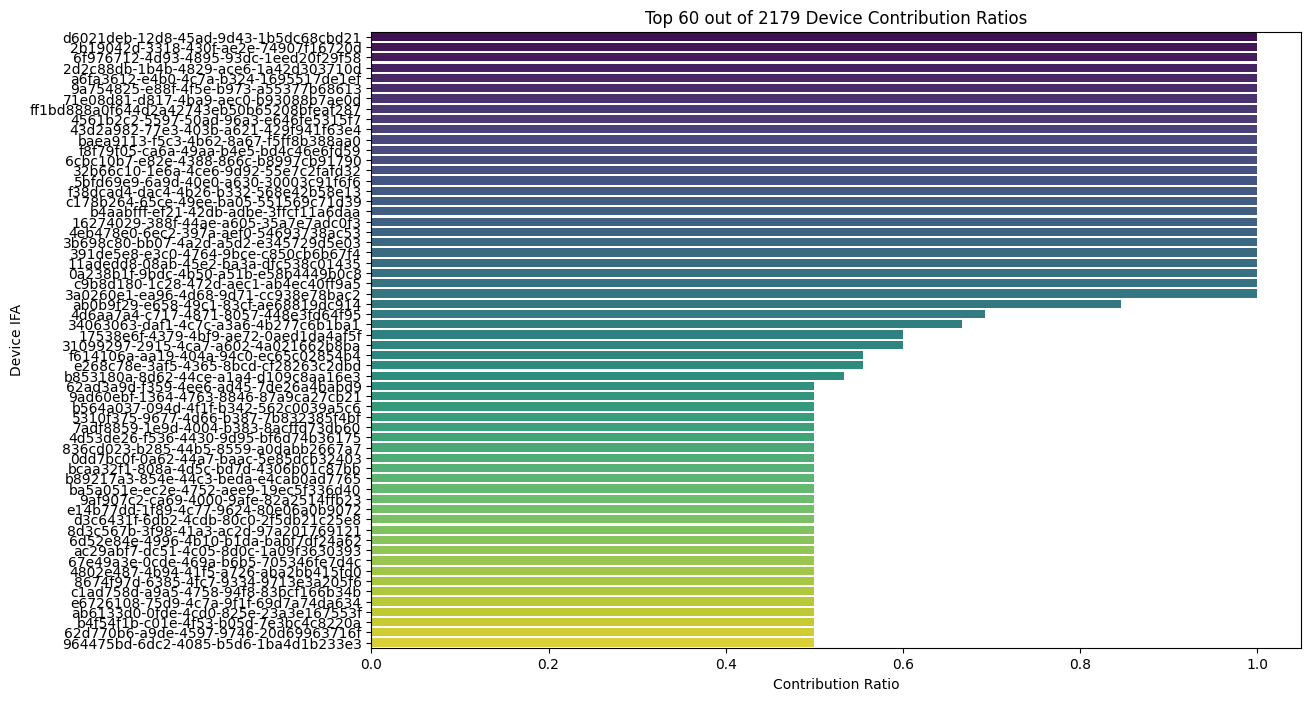

In [52]:
# Visualization: Device Contribution Ratio
plt.figure(figsize=(12, 8))
sns.barplot(data=top_devices, y='deviceIfa', x='device_contribution_ratio', ci=None, palette='viridis')

plt.title('Top 60 out of 2179 Device Contribution Ratios')
plt.xlabel('Contribution Ratio')
plt.ylabel('Device IFA')
plt.xticks(rotation=0)  # No need to rotate in a horizontal bar plot


# Analysis of Devices by Contribution Ratios graeter than IQR

## Overview of Contribution Ratios

The **device contribution ratio** is calculated as:

$$
\text{device\_contribution\_ratio} = \frac{\text{requests\_per\_device\_per\_second}}{\text{requests\_per\_second}}
$$

This metric highlights the proportion of total network traffic handled by each device. Analyzing these ratios helps identify devices that are critical to network operations, detect anomalies in device behavior, and optimize resource allocation.

The purpose of this analysis is to understand the behavior of the devices with the higher contribution ratios, than Inter Qartile Range, assess their performance, and detect any abnormal patterns that may require further investigation.

---

## Implications and Recommendations

### Performance Assessment
- Devices with high contribution ratios should be closely monitored for signs of stress or degradation. 

### Anomaly Detection
- Established baselines for normal contribution ratios for each device and set automated alerts for deviations beyond acceptable thresholds.
- Investigated any spikes in contribution ratios for potential security incidents, such as account compromise or malicious activity targeting specific devices.



In [53]:
l = top_devices["deviceIfa"].to_list()

# Filter deviceIfa in df from l list
df_unique_filtereted = df[df['deviceIfa'].isin(l)]

df_unique_filtereted.sort_values(by=["deviceIfa", "reqTimeConverted"])

,Unnamed: 0,reqTimeConverted,device_contribution_ratio,second,deviceIfa,requests_per_second,device_ifa_total_requests,burstiness
121375,121375,2025-02-01 11:24:57,0.500000,2025-02-01 11:24:57,0a238b1f-9bdc-4b50-a51b-e58b4449b0c8,2,2,1.0
121384,121384,2025-02-01 11:25:05,1.000000,2025-02-01 11:25:05,0a238b1f-9bdc-4b50-a51b-e58b4449b0c8,1,2,5.0
121576,121576,2025-02-01 11:29:51,0.500000,2025-02-01 11:29:51,0dd7bc0f-0a62-44a7-baac-5e85dcb32403,2,1,1.0
121386,121386,2025-02-01 11:25:07,0.500000,2025-02-01 11:25:07,11adedd8-08ab-45e2-ba3a-dfc538c01435,2,2,1.0
121409,121409,2025-02-01 11:25:42,1.000000,2025-02-01 11:25:42,11adedd8-08ab-45e2-ba3a-dfc538c01435,1,2,5.0
...,...,...,...,...,...,...,...,...
121473,121473,2025-02-01 11:27:58,0.500000,2025-02-01 11:27:58,f8f79f05-ca6a-49aa-b4e5-bd4c46e6fd59,2,4,5.0
121545,121545,2025-02-01 11:29:17,1.000000,2025-02-01 11:29:17,f8f79f05-ca6a-49aa-b4e5-bd4c46e6fd59,1,4,5.0
119310,119310,2025-02-01 11:21:08,0.027778,2025-02-01 11:21:08,ff1bd888a0f644d2a42743eb50b65208bfeaf287,36,3,1.0
121402,121402,2025-02-01 11:25:30,0.333333,2025-02-01 11:25:30,ff1bd888a0f644d2a42743eb50b65208bfeaf287,3,3,5.0


In [47]:
df.sort_values(by=["deviceIfa", "reqTimeConverted"])

,Unnamed: 0,reqTimeConverted,device_contribution_ratio,second,deviceIfa,requests_per_second,device_ifa_total_requests,burstiness
1411,1411,2025-01-24 10:00:13,0.010526,2025-01-24 10:00:13,00000000-0000-0000-0000-000000000000,95,160,0.010526
6303,6303,2025-01-24 10:00:57,0.010753,2025-01-24 10:00:57,00000000-0000-0000-0000-000000000000,93,160,0.002151
8608,8608,2025-01-24 10:01:17,0.010000,2025-01-24 10:01:17,00000000-0000-0000-0000-000000000000,100,160,0.002000
9200,9200,2025-01-24 10:01:23,0.008130,2025-01-24 10:01:23,00000000-0000-0000-0000-000000000000,123,160,0.001626
25359,25359,2025-01-24 10:03:38,0.008929,2025-01-24 10:03:38,00000000-0000-0000-0000-000000000000,112,160,0.001786
...,...,...,...,...,...,...,...,...
34228,34228,2025-01-24 10:04:52,0.006452,2025-01-24 10:04:52,fffab2ce-d5c1-4d26-a982-c416571e2f88,155,10,0.001290
36038,36038,2025-01-24 10:05:08,0.007692,2025-01-24 10:05:08,fffab2ce-d5c1-4d26-a982-c416571e2f88,130,10,0.001538
43665,43665,2025-01-24 10:06:10,0.007092,2025-01-24 10:06:10,fffab2ce-d5c1-4d26-a982-c416571e2f88,141,10,0.001418
21550,21550,2025-01-24 10:03:07,0.007937,2025-01-24 10:03:07,fffe99c8-40bf-4901-a29b-4de9e59ad3c9,126,1,0.007937


In [54]:
# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='device-dropdown',
        options=[{'label': device, 'value': device} for device in df_unique_filtereted['deviceIfa'].unique()],
        value=df_unique_filtereted['deviceIfa'].unique()[0]  # Default selection
    ),
    dcc.Graph(id="time-series-plot")
])

@app.callback(
    Output("time-series-plot", "figure"),
    Input("device-dropdown", "value")
)
def update_graph(selected_device):
    # Filter DataFrame for selected device
    filtered_df = df_unique_filtereted[df_unique_filtereted['deviceIfa'] == selected_device]

    # Compute Q1 and Q3 dynamically
    Q1 = filtered_df['burstiness'].quantile(0.25)
    Q3 = filtered_df['burstiness'].quantile(0.75)

    fig = go.Figure()

    # Plot Burstiness Time Series
    fig.add_trace(go.Scatter(
        x=filtered_df["second"],
        y=filtered_df["burstiness"],
        mode="lines+markers",
        name="Burstiness",
        line=dict(color="blue")
    ))

    # Plot Q1 (25th percentile)
    fig.add_trace(go.Scatter(
        x=filtered_df["second"],
        y=[Q1] * len(filtered_df),
        mode="lines",
        name="Q1 (25th Percentile)",
        line=dict(color="green", dash="dash")
    ))

    # Plot Q3 (75th percentile)
    fig.add_trace(go.Scatter(
        x=filtered_df["second"],
        y=[Q3] * len(filtered_df),
        mode="lines",
        name="Q3 (75th Percentile)",
        line=dict(color="red", dash="dash")
    ))

    # Layout settings
    fig.update_layout(
        title=f"Burstiness & IQR for Device {selected_device}",
        xaxis_title="Time",
        yaxis_title="Burstiness",
        template="plotly_white",
        hovermode="x"
    )

    return fig

if __name__ == '__main__':
    app.run(debug=True)


# Burstiness Analysis for High-Contribution Devices

## Overview of Burstiness

The **burstiness** is calculated as:

$$
\text{burstiness} = \frac{\text{requestCount}}{\text{baseline\_requests}}
$$

Burstiness measures the variability of traffic by comparing the actual number of requests ($\text{requestCount}$) to a baseline level of expected requests ($\text{baseline\_requests}$). It highlights periods of high activity (bursts) relative to normal behavior. High burstiness indicates short-term spikes in traffic, which can strain network resources and potentially signal abnormal or malicious activity.

For this analysis, we focus on devices with **device contribution ratios** greater than the IQR range. These devices are already contributing disproportionately to network traffic, making their burstiness particularly relevant for identifying anomalies or performance bottlenecks.

---

## Key Findings and Insights

### 1. **High Burstiness in High-Contribution Devices**
- Devices with high burstiness values exhibit significant short-term traffic spikes relative to their baseline activity.
- These spikes could indicate:
  - **Legitimate operational surges**: For example, devices handling critical tasks during peak times.
  - **Potential anomalies**: Such as Distributed Denial of Service (DDoS) attacks, misconfigurations, or compromised devices generating excessive traffic.

### 2. **Anomalous Traffic Patterns**
- Some devices show extreme burstiness values compared to others in the high-contribution group. These outliers may signal:
  - Unusual usage patterns or operational inefficiencies.
  - Security incidents such as botnet activity or brute-force attacks targeting specific devices.

---

## Conclusion

The burstiness analysis reveals critical insights into the traffic patterns of high-contribution devices. While some level of burstiness is expected due to normal operational variability, extreme values warrant closer attention as they may indicate inefficiencies or security risks. By proactively monitoring and managing these devices, organizations can ensure smoother network performance while mitigating potential threats.
